# Introduction

In [10]:
import torch
from AutoDecoder import AutoDecoder
from utils import create_dataloaders, plot_tsne
from evaluate import evaluate_model
import matplotlib.pyplot as plt
import os

In [2]:
# Load the dataset (train and test splits are handled in the function)
train_ds, train_dl, test_ds, test_dl = create_dataloaders(data_path='dataset', batch_size=64, shuffle=True, num_workers=2)

# Debugging: Check if the datasets ddare loaded properly
print(f"Training dataset size: {len(train_ds)}")
print(f"Test dataset size: {len(test_ds)}")
print(f"Number of batches in training DataLoader: {len(train_dl)}")
print(f"Number of batches in test DataLoader: {len(test_dl)}")

Training dataset size: 1000
Test dataset size: 1000
Number of batches in training DataLoader: 16
Number of batches in test DataLoader: 16


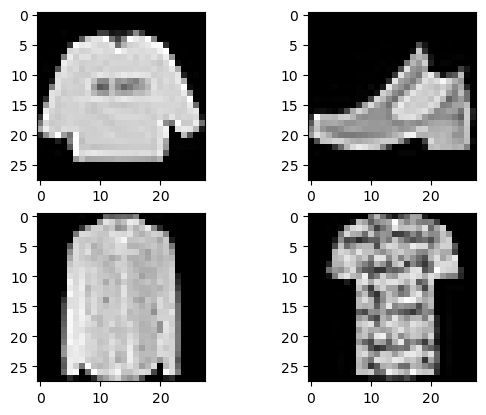

Image size: torch.Size([28, 28])


In [3]:
#explore the training dataset
plt.figure(1)
num_samples = 4
for i in range(num_samples):
    plt.subplot(221+i)
    plt.imshow(train_ds[i][1], cmap='gray')
plt.show()

#lets see the size of the images
print(f"Image size: {train_ds[0][1].shape}")

In [7]:
#lets have a look at the values of the pixels of the images
print(f"Min pixel value: {train_ds[0][1].min()}")
print(f"Max pixel value: {train_ds[0][1].max()}")

# TODO: consider if we need to normalize the images
# for i in range(len(train_ds)):
#     train_ds[i] = (train_ds[i][0], train_ds[i][1].float()/255)

Min pixel value: 0
Max pixel value: 255


# AutoDecoder

## AutoDecoder Implementation Overview

In [11]:
from AutoDecoder import Trainer
trainer = Trainer()
print(trainer.model)

AutoDecoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Sigmoid()
  )
)


### Architecture and Design Choices

#### 1. **Decoder Architecture**
The AutoDecoder reconstructs images from a latent space representation using a fully convolutional structure with transposed convolution layers. The reason we are using transposed convolution layers is for upsampling, and also we want to imitate "miror imaging" of the Encoder (which is not present). Also, we took inspiration for the architecture of the decoder from the following paper - arXiv:1512.09300v2 [here](https://arxiv.org/abs/1512.09300).
Below is the architecture:

- **Input**: Latent vector of size $latent\_dim$, reshaped to $(\text{batch\_size}, \text{latent\_dim}, 1, 1)$.
- **Output**: Reconstructed images of size $28\times 28$ with pixel values scaled to $[0, 255]$.

#### Layer Details:
1. **Transposed Convolution Layers**:
   - **Layer 1**: Converts the latent vector into a feature map of size $7 \times 7$ with $256$ channels.
   - **Layer 2**: Upsamples the feature map to $14 \times 14$ with $128$ channels.
   - **Layer 3**: Further upsamples to $28 \times 28$ with 64 channels.
   - **Layer 4**: Outputs the final image with 1 channel (grayscale as the inputs) using a $3 \times 3$.


2. **Activation Functions**:
   - **ReLU**: Used in intermediate layers to introduce non-linearity.
   - **Sigmoid**: Used in the output layer to normalize pixel values to $[0, 1]$. This output is multiplied by 255 in order for the values to be in the same scale as the data.


3. **Batch Normalization**:
   - Applied after each transposed convolution (except the last layer) to stabilize training and improve convergence.


4. **Upsampling**:
   - Achieved through transposed convolutions, which increase the spatial dimensions while learning meaningful patterns to fill in details. We remind that the input vector to the decoder is a vector in a smaller dimebsion so we need to "fill in" patterns in order to compare to the data.

---

### Model Parameters

1. **Kernel Size**:
   - Larger $7 \times 7$ kernel at the first layer captures broad features, while smaller kernels in later layers refine finer details.
   - We also used the following equations from the pytorch documnetation [here](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html):
   - $H_{\text{out}} = (H_{\text{in}} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0] + \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) + \text{output\_padding}[0] + 1 $
   - $W_{\text{out}} = (W_{\text{in}} - 1) \times \text{stride}[1] - 2 \times \text{padding}[1] + \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) + \text{output\_padding}[1] + 1$



2. **Strides and Padding**:
   - Configured such that it would ensure smooth upsampling.


3. **Model Depth**:
   - Four transposed convolution layers provide sufficient capacity to reconstruct $28 \times 28$ images without overfitting. Recall we took inspiration from the above paper.


4. **Latent Dimension**:
   - We needed to choose a dimnsion that is smaller than the dimension of the data $28 \times 28 =784$. This is because the latent space represents a more compressed space of the data.
   - After experimentation where we observed the latents dimesion's effect the model's ability to generalize, we chose $latent\_dim=128$.
   - The latent dimension gives a good balance between reducing the dimensionality of the latent space for compact representation and maintaining a higher dimensional size to enable the model to capture more complex features for better reconstruction.

---

### Training Parameters

1. **Optimizer**: 
   - **Adam Optimizer**: Selected for its adaptive learning rate and momentum, ensuring stable and efficient optimization.
   - Adaptive learning rate is when the learning rate for each parameter is adjusted individually based on how frequently it has been updated. Momentum uses past gradient information to smooth out updates and avoid oscillations.


2. **Learning Rate**: 
   - Set to $0.005$, a starting value that gave stable convergence.


3. **Loss Function**:
   - **Reconstruction Loss**: Gave by the staff to use.


4. **Batch Size**: 
   - $batch\_size=64$: Provided a balance between computational efficiency and stable gradient updates.


5. **Epochs**: 
   - Trained for 100 epochs in order to minimize reconstruction loss.


In [8]:
trainer.train_and_evaluate()

Epoch 1/100
Epoch [1/100], Loss: 0.5627
Epoch 2/100
Epoch [2/100], Loss: 0.4485
Epoch 3/100
Epoch [3/100], Loss: 0.4183
Epoch 4/100
Epoch [4/100], Loss: 0.3949
Epoch 5/100
Epoch [5/100], Loss: 0.3646
Epoch 6/100
Epoch [6/100], Loss: 0.3154
Epoch 7/100
Epoch [7/100], Loss: 0.2878
Epoch 8/100
Epoch [8/100], Loss: 0.2830
Epoch 9/100
Epoch [9/100], Loss: 0.2313
Epoch 10/100
Epoch [10/100], Loss: 0.2062
Epoch 11/100
Epoch [11/100], Loss: 0.1973
Epoch 12/100
Epoch [12/100], Loss: 0.1914
Epoch 13/100
Epoch [13/100], Loss: 0.2016
Epoch 14/100
Epoch [14/100], Loss: 0.1910
Epoch 15/100
Epoch [15/100], Loss: 0.1697
Epoch 16/100
Epoch [16/100], Loss: 0.1675
Epoch 17/100
Epoch [17/100], Loss: 0.1704
Epoch 18/100
Epoch [18/100], Loss: 0.1582
Epoch 19/100
Epoch [19/100], Loss: 0.1418
Epoch 20/100
Epoch [20/100], Loss: 0.1342
Epoch 21/100
Epoch [21/100], Loss: 0.1313
Epoch 22/100
Epoch [22/100], Loss: 0.1350
Epoch 23/100
Epoch [23/100], Loss: 0.1325
Epoch 24/100
Epoch [24/100], Loss: 0.1242
Epoch 25/1

### TSNE Plot

<p style="font-size:16px;">Plotting TSNE plot.</p>

In [9]:
trainer.plot_tsne()

Generating t-SNE plot...


<Figure size 800x600 with 0 Axes>

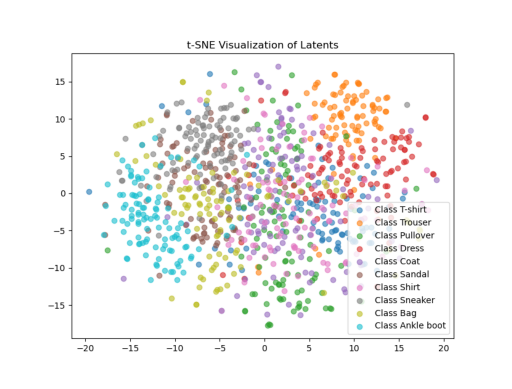

In [31]:
file_name = 'tsne_plot_AD'
image_path = f'{file_name}.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

We can see from the plot that there are som classes are organized well, but overall the classes arent seperated well. This is probably due to the fact that the model didn't learn a continuous space but rather a mapping from latent vectors to a reconstructed image similar to the data.

### Testing Samples

In [10]:
trainer.test_samples()

Generating random samples...
Saving images...
Images saved to output_images/random_latents_images.png
Saving images...
Images saved to output_images/test_set_latents_images.png


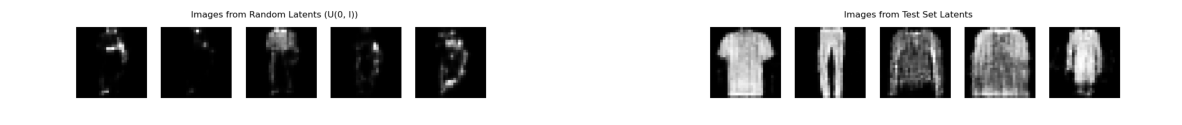

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_paths = ['output_images/random_latents_images.png', 'output_images/test_set_latents_images.png']

fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))  # 1 row, len(image_paths) columns

for i, image_path in enumerate(image_paths):
    img = mpimg.imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide axes

plt.show()

#### Comparing Random & Test Images

##### **Results Comparission**

- We can see that the decoded test set latents gave far better results than the decoded latents from $U(0,I)$.
- The decoder learned to take a mapping of a certain image in the latent space and to construct it to an image that is close to the original one. The test latents were fitted to a close mapping in the latent space of similar images. Then the Decoder can take the test latent and reconstruct an image that is similar to the images in the data.
- On the other hand, latent vectors that were sampled randomly from $U(0,I)$ were not fitted and therefore the decoder did not learn how to construct images similiar to the data images from their mappings in the latent space.


# Variational Auto Decoder - VAD

## VariationalAutoDecoder Implementation Overview

In [1]:
from VariationalAutoDecoder import VariationalAutoDecoderNormal, VariationalAutoDecoderLaplace, VariationalAutoDecoderExponential
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
learning_rate = 0.02
latent_dim = 60
model_normal = VariationalAutoDecoderNormal(latent_dim=latent_dim,lr=learning_rate)
print(model_normal.decoder)

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=60, out_features=12544, bias=True)
    (1): ReLU(inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Sigmoid()
  )
)


### Architecture and Design Choices

#### 1. **Decoder Architecture**
The Decoder architecture in the VAD is very similar to the AutoDecoder architecture:
We first use a fully connected layer for the decoder to learn how to upsample a vector from the the latent space. We then use RELU to introduce non-linearity and after that we unflattent the result vector in order for it to be in proper dimensions for the convolutional layers.

Then we use fully convolutional structure with transposed convolution layers. The reason we are using transposed convolution layers is for upsampling, and also we want to imitate "miror imaging" of the Encoder (which is not present). Also, we took inspiration for the architecture of the decoder from the following paper - arXiv:1512.09300v2 [here](https://arxiv.org/abs/1512.09300).
Below is the architecture:

- **Input**: Latent vector of size $latent\_dim$\.
- **Output**: Reconstructed images of size $28\times 28$ with pixel values scaled to $[0, 255]$.

#### Layer Details

1. **Fully Connected Layer and Reshaping**:
   - **Layer 0**: Maps the latent vector into a feature vector of size $256 \times 7 \times 7 = 12544$.
   - **Reshape**: Converts the output into a feature map with dimensions $7 \times 7$ and $256$ channels, preparing it for convolutional decoding.

2. **Transposed Convolution Layers**:
   - **Layer 1**: Upsamples the feature map from $7 \times 7$ to $14 \times 14$ with $128$ channels.
   - **Layer 2**: Further upsamples the feature map to $28 \times 28$ with $64$ channels.
   - **Layer 3**: Outputs the final image with $1$ channel (grayscale, as the inputs) using a $3 \times 3$ kernel.


3. **Activation Functions**:
   - **ReLU**: Applied after each intermediate layer to introduce non-linearity and allow the model to learn complex relationships.
   - **Sigmoid**: Applied in the output layer to normalize pixel values to the range $[0, 1]$, and then multiplied by $255$ aligning with the expected intensity values of the data.


4. **Batch Normalization**:
   - Included after each transposed convolution layer (except the last) to stabilize learning by normalizing activations, improving convergence and reducing overfitting.


5. **Upsampling**:
   - Performed using transposed convolutions, which increase the spatial dimensions of the feature maps while learning patterns to generate meaningful reconstructions.  
   - This step is crucial as the input vector to the decoder is a compressed representation, and the decoder must "expand" and "fill in" details to recreate an image comparable to the original data.

---

### Model Parameters

1. **Kernel Size**:
   - A $4 \times 4$ kernel is used in the first two transposed convolution layers to upsample and capture broad patterns efficiently. The final layer uses a smaller $3 \times 3$ kernel to refine details in the reconstructed image.
   - The output dimensions after each layer were calculated using the equations from the PyTorch documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html):
     - $H_{\text{out}} = (H_{\text{in}} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0] + \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) + \text{output\_padding}[0] + 1$
     - $W_{\text{out}} = (W_{\text{in}} - 1) \times \text{stride}[1] - 2 \times \text{padding}[1] + \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) + \text{output\_padding}[1] + 1$

2. **Stride**:
   - A stride of $2 \times 2$ in the first two layers doubles the spatial dimensions of the feature maps, enabling effective upsampling.

3. **Padding**:
   - Padding of $1 \times 1$ ensures the output dimensions grow proportionally while maintaining spatial consistency during upsampling.

3. **Model Depth**:
   - Three transposed convolution layers provide sufficient capacity to reconstruct $28 \times 28$ images without overfitting. Recall we took inspiration from the above paper.

4. **Latent Dimension**:
   - After experimentation where we observed the latents dimesion's effect on the VAD loss and the model's ability to generalize, we chose $latent\_dim=60$.
   - The latent dimension gives a good balance between reducing the dimensionality of the latent space for compact representation and maintaining a higher dimensional size to enable the model to capture more complex features for better reconstruction.

---

### Training Parameters

#### Overview:
The parametes that were trained in the model except for the decoder, were the log of the variance and the mean for each training sample.
Training the log of the variance helps ensure numerical stability and precision during the training process.

After experimanting we found that the following hyper-parameters balance well between the reconstruction of images and the orginaization of a learned continuos latent space.

1. **Optimizer**: 
   - **Adam Optimizer**: Selected for its adaptive learning rate and momentum, ensuring stable and efficient optimization.
   - Adaptive learning rate is when the learning rate for each parameter is adjusted individually based on how frequently it has been updated. Momentum uses past gradient information to smooth out updates and avoid oscillations.

2. **Learning Rate**: 
   - Set to $0.02$, a starting value that gave stable convergence.

3. **Loss Function**:
   - The loss function combines two key components: the **reconstruction loss** and the **KL-Divergence loss**. These terms work together to balance reconstruction accuracy and the organization of the latent space.

   - **Reconstruction Loss**: 
     - The reconstruction term in the loss function measures how accurately the decoder can generate an image that is similar to the original input. This guides the model in outputing new images that are similar to the input images during training.
     - We use Mean Squared Error (MSE) for the reconstruction term.
     - **Purpose**: MSE measures the pixel-wise difference between the original input image and the reconstructed image, providing an evaluation of reconstruction quality. It penalizes larger errors more heavily, ensuring that even small differences in pixel values are minimized.
     - **Why MSE?**: MSE aligns well with our goal of producing outputs visually close to the input. It was also used in the tutorials robust loss for tasks involving grayscale images.

   - **KL-Divergence Loss**:
     - The KL divergence term in the loss measures how closely the learned latent space distribution matches the target distribution, which is a standard normal distribution. Its purpose is to guide the model in generating better samples from the latent space. This enables us to sample from the prior target distibution, decode the samples, and obtain reconstructions that are consistent with the distribution $P(X)$.
     - **Purpose**: This term ensures that the latent space remains structured and meaningful, allowing for smooth interpolation. Without it, the latent space might become disorganized, leading to poor generalization when decoding random samples. Also, this term sgives aregularization effect.

   - **Total Loss**:
     - The total loss is computed as the weighted sum of the two terms:
       $\text{Loss} = \text{Reconstruction Loss (MSE)} + \beta \cdot \text{KL-Divergence Loss}$.
       Where $\beta$ controls the trade-off between the reconstruction of the image and latent space regularization.
     - A good balance ensures that the decoder reconstructs images accurately while also allowing meaningful latent space manipulation for generative tasks.


4. **Batch Size**: 
   - $batch\_size=64$: Provided a balance between computational efficiency and stable gradient updates.

5. **Epochs**: 
   - After experimenting with fixed hyper-parameters, we observed that as we increased the epochs the KL-divergence term increased resulting in a disorganized latent space. On the other hand the reconsruction quality becomes better.

----

<p style="font-size:20px;">In the next cells you can see graphs of the different losses with 500 epochs. As a result, we reduced the number of epochs and achieved a better balance between the reconstruction and the organization of the latent space.</p>



Training the VAD model...
Epoch 1, Loss: 13259.3134
Epoch 2, Loss: 12410.5403
Epoch 3, Loss: 12308.5509
Epoch 4, Loss: 12274.4090
Epoch 5, Loss: 12222.3741
Epoch 6, Loss: 12188.5266
Epoch 7, Loss: 12139.5375
Epoch 8, Loss: 12087.9155
Epoch 9, Loss: 12049.8812
Epoch 10, Loss: 12026.7215
Epoch 11, Loss: 11990.9553
Epoch 12, Loss: 11964.7543
Epoch 13, Loss: 11953.5144
Epoch 14, Loss: 11930.8652
Epoch 15, Loss: 11908.8834
Epoch 16, Loss: 11899.1290
Epoch 17, Loss: 11893.6760
Epoch 18, Loss: 11869.4943
Epoch 19, Loss: 11858.5427
Epoch 20, Loss: 11842.0583
Epoch 21, Loss: 11829.7930
Epoch 22, Loss: 11814.9371
Epoch 23, Loss: 11812.1118
Epoch 24, Loss: 11795.8286
Epoch 25, Loss: 11782.0183
Epoch 26, Loss: 11779.1500
Epoch 27, Loss: 11773.0139
Epoch 28, Loss: 11763.7200
Epoch 29, Loss: 11748.9169
Epoch 30, Loss: 11749.6939
Epoch 31, Loss: 11801.3149
Epoch 32, Loss: 11850.5290
Epoch 33, Loss: 11765.9276
Epoch 34, Loss: 11747.9059
Epoch 35, Loss: 11715.6211
Epoch 36, Loss: 11700.0742
Epoch 37, L

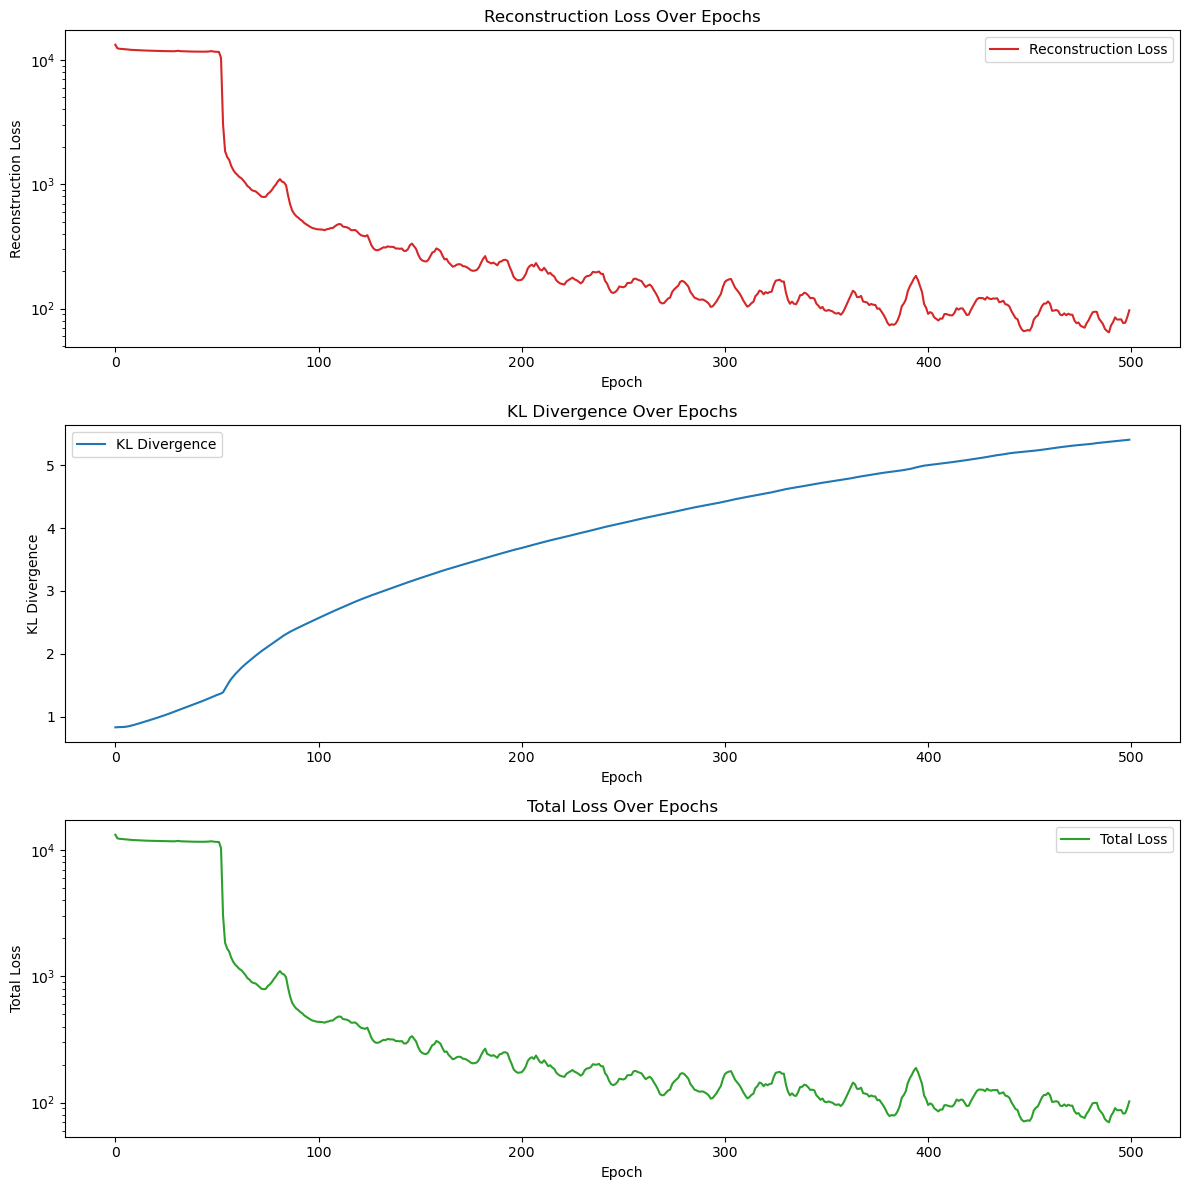

Training loss: 102.2998
Testing the VAD model...
Test loss: 0.0926


In [7]:
epochs = 500
beta = 1
train_loss,_,_ = model_normal.train_model(num_epochs=epochs, beta=beta)
print(f'Training loss: {train_loss:.4f}')
test_loss = model_normal.test_vad(num_epochs=epochs, learning_rate=learning_rate)
print(f'Test loss: {test_loss:.4f}')

We can see from the plots of the losses that around $100$ the reconstruction loss reduces dramatically but the kl-divergence still isn't too high. Therefore we chose to train the model with $100$ epochs.

<p style="font-size:16px;">Plotting TSNE plot.</p>

In [9]:
file_name = 'tsne_plot_VAD_normal_high_epochs'
image_title = 'TSNE Plot VAD Normal Distribution'
model_normal.plot_tsne(file_name=file_name, plot_title=image_title)

Generating t-SNE plot...


<Figure size 800x600 with 0 Axes>

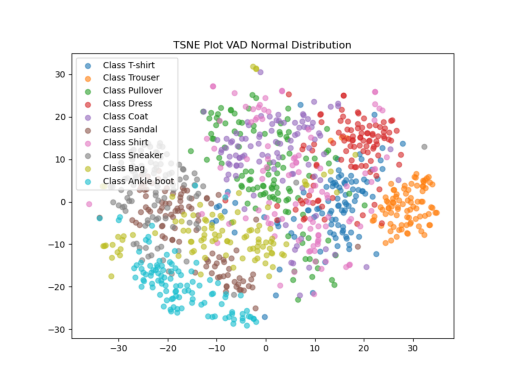

In [10]:
image_path = f'{file_name}.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

#### Results Eplanation
We can see that some classes are organized well but others are not.
For example Sandals are sperated and some are very close to ankle boots.

<p style="font-size:16px;">Training with less epochs.</p>

Training the VAD model...
Epoch 1, Loss: 15048.1314
Epoch 2, Loss: 12871.0378
Epoch 3, Loss: 12819.0642
Epoch 4, Loss: 12740.5804
Epoch 5, Loss: 12707.8270
Epoch 6, Loss: 12701.8346
Epoch 7, Loss: 12683.9619
Epoch 8, Loss: 12664.6707
Epoch 9, Loss: 12671.0497
Epoch 10, Loss: 12635.9783
Epoch 11, Loss: 12612.2809
Epoch 12, Loss: 12596.0453
Epoch 13, Loss: 12564.5851
Epoch 14, Loss: 12547.1888
Epoch 15, Loss: 12526.6371
Epoch 16, Loss: 12515.9873
Epoch 17, Loss: 12511.8053
Epoch 18, Loss: 12508.3286
Epoch 19, Loss: 12498.5405
Epoch 20, Loss: 12498.1283
Epoch 21, Loss: 12510.4091
Epoch 22, Loss: 12478.1613
Epoch 23, Loss: 12465.2444
Epoch 24, Loss: 12460.7639
Epoch 25, Loss: 12453.1063
Epoch 26, Loss: 12460.5997
Epoch 27, Loss: 12448.6783
Epoch 28, Loss: 12444.4969
Epoch 29, Loss: 12441.4703
Epoch 30, Loss: 12449.4030
Epoch 31, Loss: 12425.4092
Epoch 32, Loss: 12422.0073
Epoch 33, Loss: 12416.6343
Epoch 34, Loss: 12416.8032
Epoch 35, Loss: 12408.9325
Epoch 36, Loss: 12406.0832
Epoch 37, L

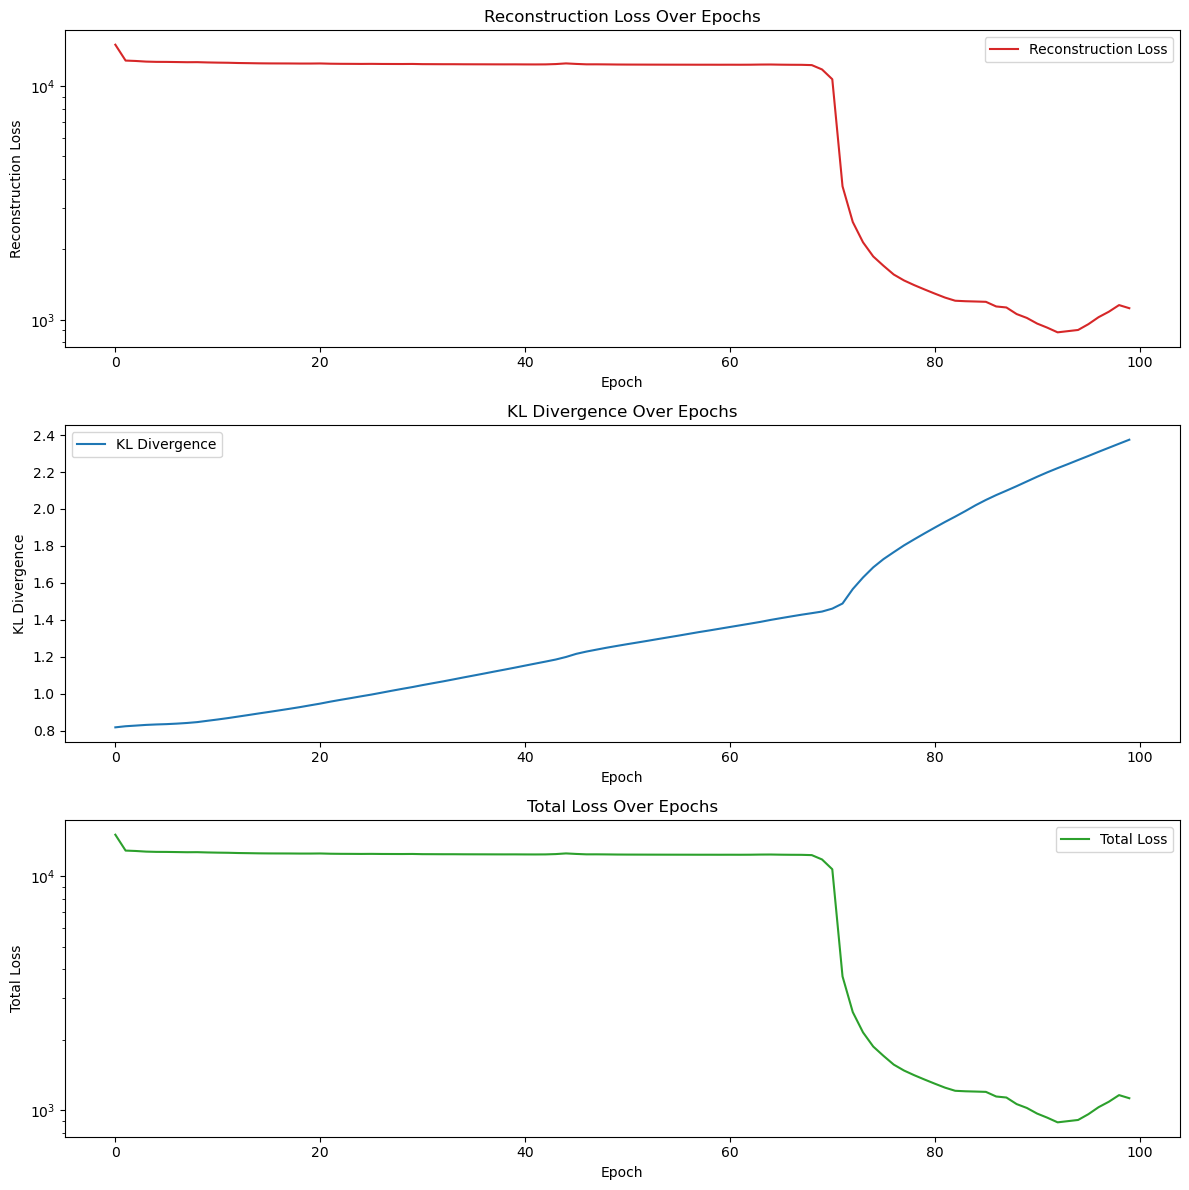

Training loss: 1122.8492
Testing the VAD model...
Test loss: 0.1181


In [18]:
epochs = 100
beta = 1
learning_rate = 0.02
latent_dim = 60
model_normal = VariationalAutoDecoderNormal(latent_dim=latent_dim,lr=learning_rate)
train_loss,_,_ = model_normal.train_model(num_epochs=epochs, beta=beta)
print(f'Training loss: {train_loss:.4f}')
test_loss = model_normal.test_vad(num_epochs=epochs, learning_rate=learning_rate)
print(f'Test loss: {test_loss:.4f}')

<p style="font-size:16px;">Plotting TSNE plot.</p>

In [20]:
file_name = 'tsne_plot_VAD_normal'
image_title = 'TSNE Plot VAD Normal Distribution'
model_normal.plot_tsne(file_name=file_name, plot_title=image_title)

Generating t-SNE plot...


<Figure size 800x600 with 0 Axes>

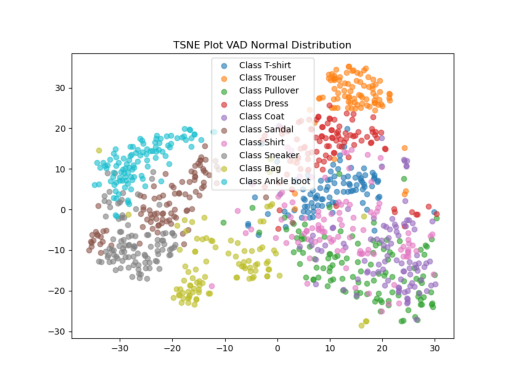

In [21]:
image_path = f'{file_name}.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Results Eplanation
We can see that over all the classes are organized well.
From the plot we can observe that the different shoe classes are near each others, but the model learnt to distinguish between the different kind of shoes (sandals, sneakers, ankle boots).
The same explanation applies to the dress and trousers classes.
Besides that we can observe that the classes coat, pullover and and shirt are not seperated well in the latent space. This due to the fact that these classes have features that are difficult for the model to capture and differentuate between them.
Lastly we see that the bag class is very much apart from other classes but has two different clusters. This is probably due to the fact that are two kinds of bags.

#### Bags Class - different bags

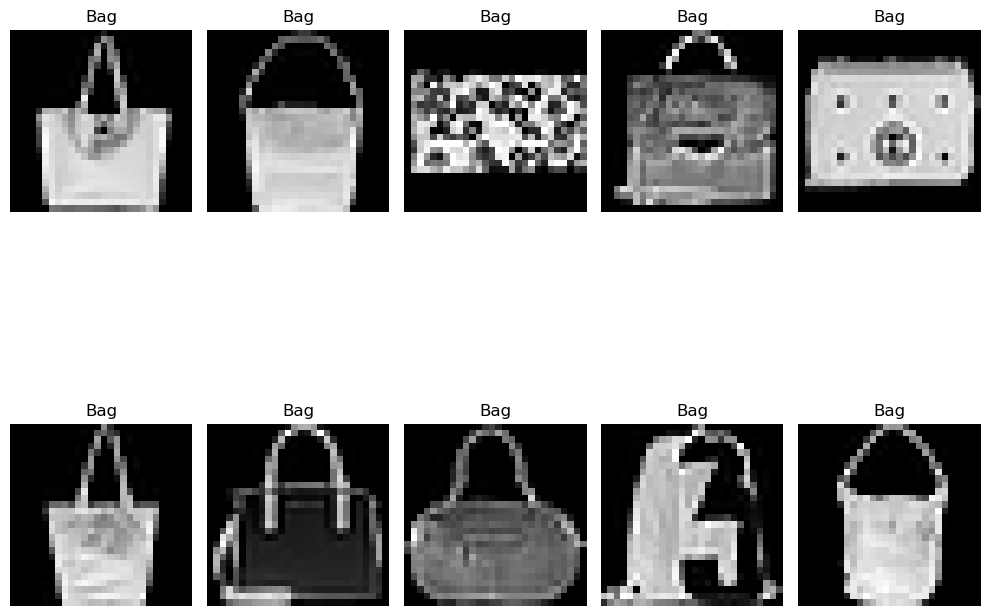

In [27]:
BAG_CLASS = 8
bag_images = [model_normal.train_ds.X[i] for i in range(len(model_normal.train_ds)) if model_normal.train_ds.y[i] == BAG_CLASS]
bag_images = bag_images[-5:] + bag_images[:5]

# Plot 10 bag images
plt.figure(figsize=(10, 10))
for i, img in enumerate(bag_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Bag")
plt.tight_layout()
plt.show()

We can see that there are two different types of bags - bags with a strap and amore enveloped type of bag.

#### Shirt, Pullover & Coat Classes

In [28]:
PULLOVER_CLASS = 2
COAT_CLASS = 4
SHIRT_CLASS = 6

pullover_images = [model_normal.train_ds.X[i] for i in range(len(model_normal.train_ds)) if model_normal.train_ds.y[i] == PULLOVER_CLASS]
pullover_images = pullover_images[-5:] + pullover_images[:5]

coat_images = [model_normal.train_ds.X[i] for i in range(len(model_normal.train_ds)) if model_normal.train_ds.y[i] == COAT_CLASS]
coat_images = coat_images[-5:] + coat_images[:5]

shirt_images = [model_normal.train_ds.X[i] for i in range(len(model_normal.train_ds)) if model_normal.train_ds.y[i] == SHIRT_CLASS]
shirt_images = shirt_images[-5:] + shirt_images[:5]

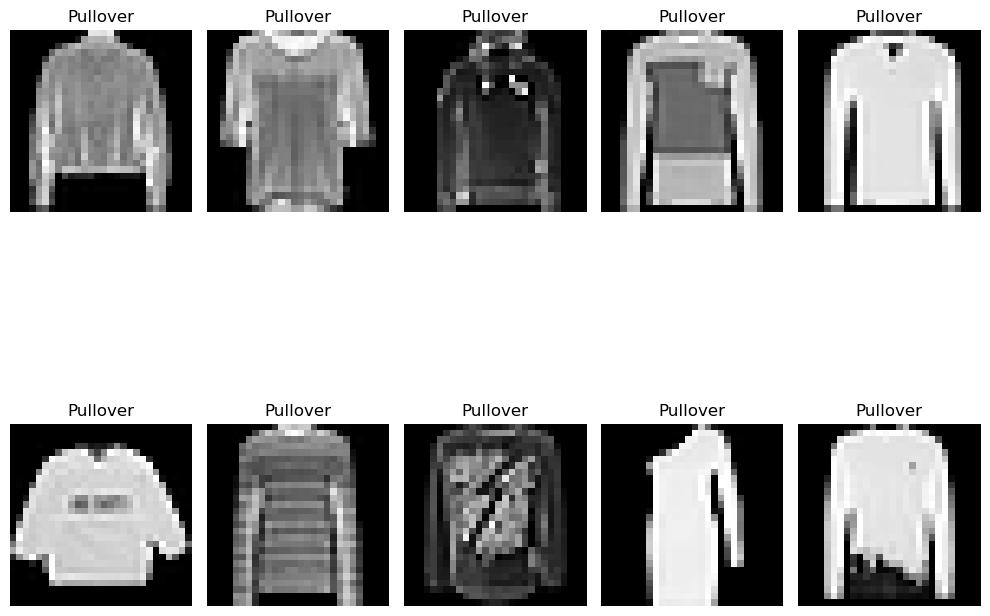

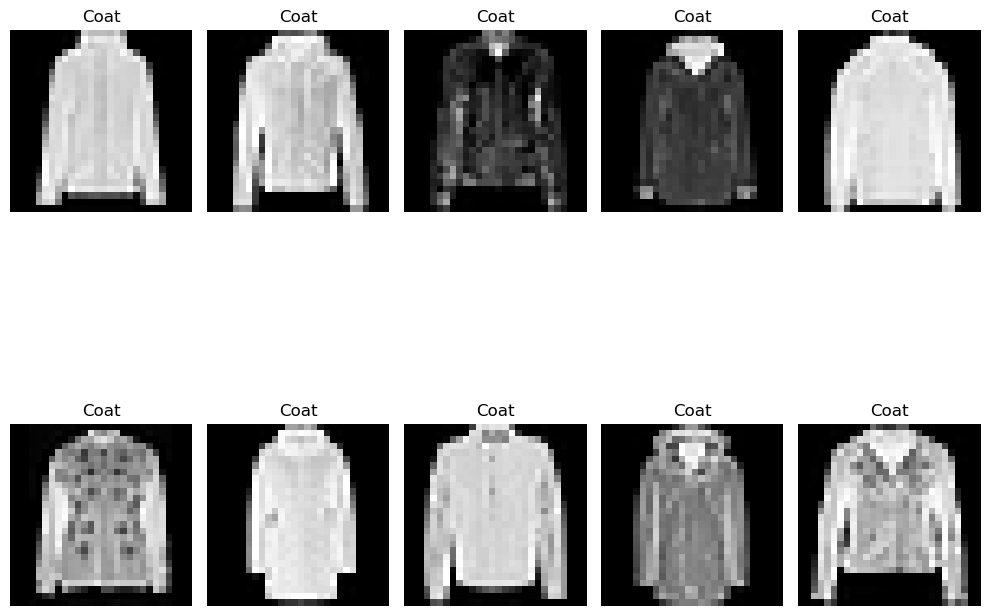

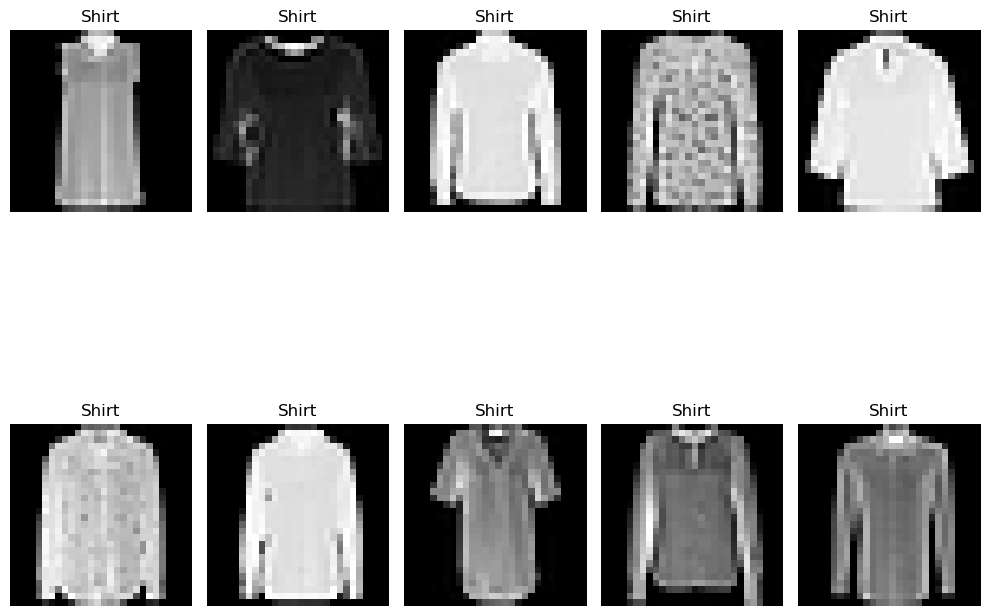

In [30]:
# Plot 10 pullover images
plt.figure(figsize=(10, 10))
for i, img in enumerate(pullover_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Pullover")
plt.tight_layout()
plt.show()

# Plot 10 coat images
plt.figure(figsize=(10, 10))
for i, img in enumerate(coat_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Coat")
plt.tight_layout()
plt.show()

# Plot 10 shirt images
plt.figure(figsize=(10, 10))
for i, img in enumerate(shirt_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Shirt")
plt.tight_layout()
plt.show()

As we can see from the images above, it is very hard to tell the difference between the three classes.

### Using Different Distributions

#### Laplace Distibution

We decided to use the laplace distribution.
The laplace distribution is known for producing sparse representations due to its sharper peak around the mean. Sparse representations allow the latent space to focus on the most important features of the data. Moreover, the laplace distribution has a sharp peak around the mean, and the probability of extreme values decreases more slowly than it does for the normal distribution. This is why the distribution's extreme values are still relatively more likely. In data that contains rare but significant features, the laplace distribution can represent such variability. This can help distinguish between similar classes.

In order to use the distribution in our VAD we changed the reparameterization trick such that epsilon was sampled from the laplace distribution. Also, we adjusted the loss function accordingly.


#### Training VAD with Laplace Distribution

Training the VAD model...
Epoch 1, Loss: 12774.5704
Epoch 2, Loss: 12228.7070
Epoch 3, Loss: 11364.8144
Epoch 4, Loss: 8511.4837
Epoch 5, Loss: 7739.5282
Epoch 6, Loss: 7173.8735
Epoch 7, Loss: 6858.1567
Epoch 8, Loss: 6606.2087
Epoch 9, Loss: 6334.9317
Epoch 10, Loss: 6087.4608
Epoch 11, Loss: 5961.3867
Epoch 12, Loss: 5821.5327
Epoch 13, Loss: 5521.0844
Epoch 14, Loss: 5338.5537
Epoch 15, Loss: 5130.0866
Epoch 16, Loss: 5044.2687
Epoch 17, Loss: 4681.9963
Epoch 18, Loss: 4639.7677
Epoch 19, Loss: 4473.3933
Epoch 20, Loss: 4337.7189
Epoch 21, Loss: 4291.1651
Epoch 22, Loss: 4187.4885
Epoch 23, Loss: 4039.9329
Epoch 24, Loss: 3933.6825
Epoch 25, Loss: 3836.8355
Epoch 26, Loss: 3902.9469
Epoch 27, Loss: 3723.2748
Epoch 28, Loss: 3599.4070
Epoch 29, Loss: 3426.7274
Epoch 30, Loss: 3410.0884
Epoch 31, Loss: 3313.8777
Epoch 32, Loss: 3144.2045
Epoch 33, Loss: 3152.2284
Epoch 34, Loss: 3101.2085
Epoch 35, Loss: 3018.1644
Epoch 36, Loss: 2986.5164
Epoch 37, Loss: 2869.8799
Epoch 38, Loss: 28

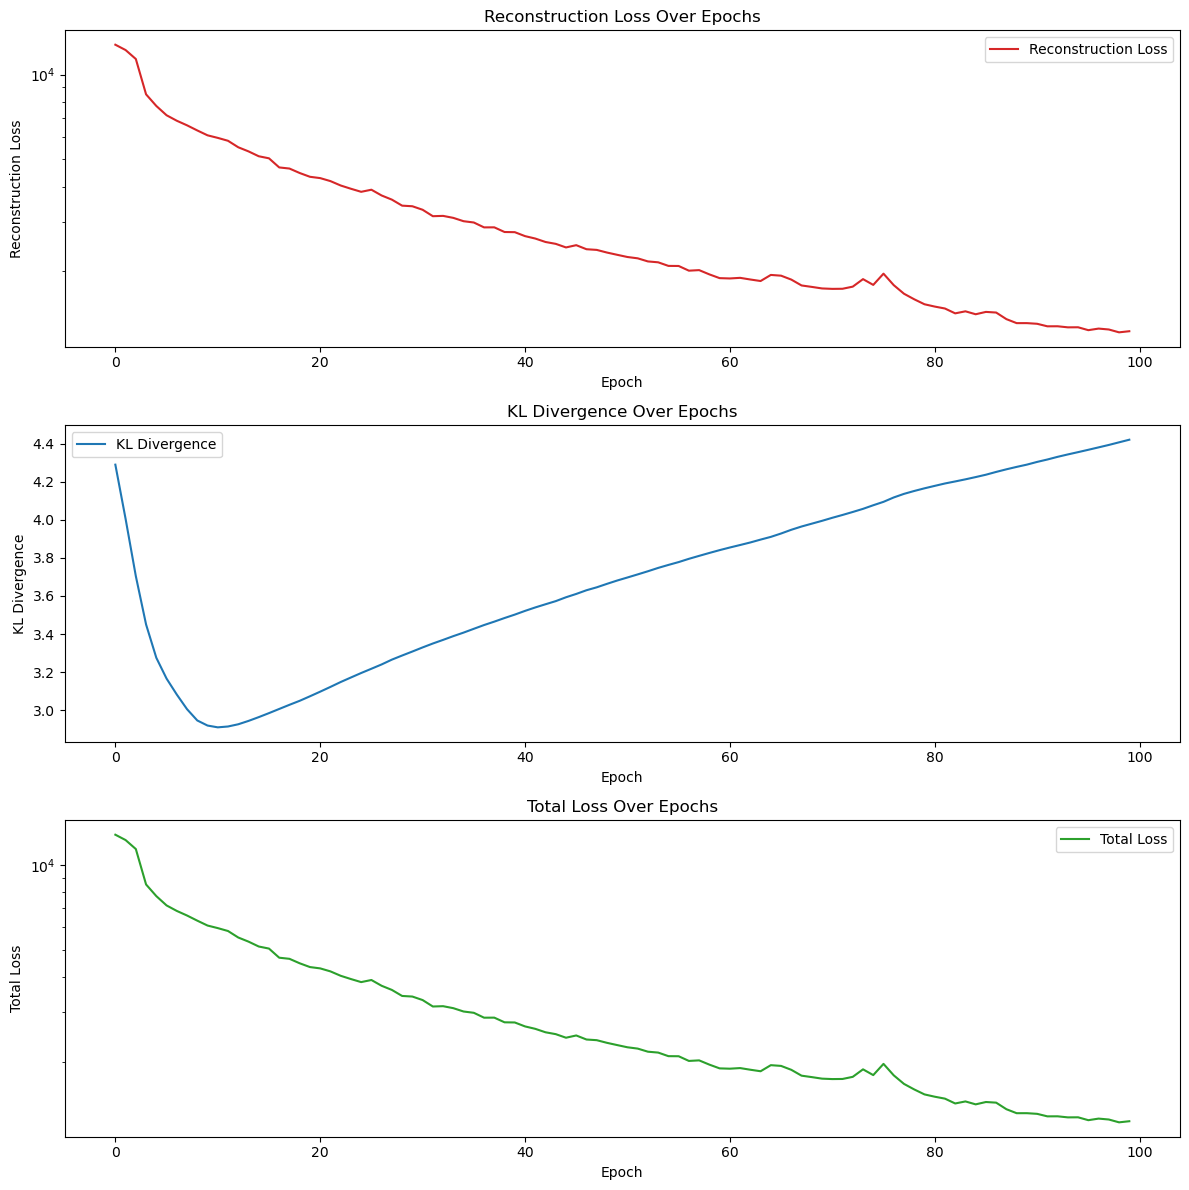

Training loss: 1232.7756
Testing the VAD model...
Test loss: 0.1334


In [15]:
epochs = 100
beta = 2
learning_rate = 0.03
latent_dim = 60
model_laplace = VariationalAutoDecoderLaplace(latent_dim=latent_dim,lr=learning_rate)
train_loss,_,_ = model_laplace.train_model(num_epochs=epochs, beta=beta)
print(f'Training loss: {train_loss:.4f}')
test_loss = model_laplace.test_vad(num_epochs=epochs, learning_rate=learning_rate)
print(f'Test loss: {test_loss:.4f}')

In [16]:
file_name = 'tsne_plot_VAD_laplace'
image_title = 'TSNE Plot VAD Laplace Distribution'
model_laplace.plot_tsne(file_name=file_name, plot_title=image_title)

Generating t-SNE plot...


<Figure size 800x600 with 0 Axes>

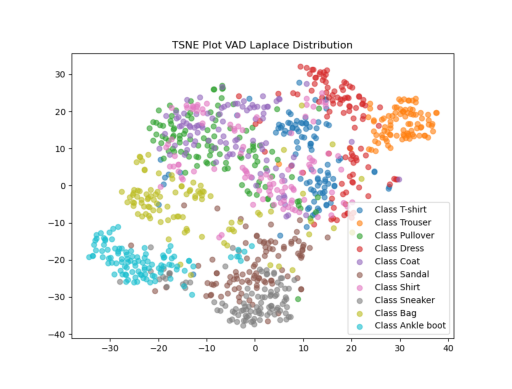

In [17]:
image_path = f'{file_name}.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Results Explanation
We can see that overall the classes are organized well, but there are some differences from the previous plot.
Firstly, the model probably found features in the dress class that distinguish the different dresses. That is the reason the dress class has two different areas. The same applies to the T-shirt class.
Moreover, we can observe that the pullover class is more concentrated rather than in the previous class. This is probably due to characteristics of the laplace distribution - able to represent rare features in the data.

In [19]:
DRESS_CLASS = 3
TSHIRT_CLASS = 0

dress_images = [model_laplace.train_ds.X[i] for i in range(len(model_laplace.train_ds)) if model_laplace.train_ds.y[i] == DRESS_CLASS]
dress_images = dress_images[-5:] + dress_images[:5]

tshirt_images = [model_laplace.train_ds.X[i] for i in range(len(model_laplace.train_ds)) if model_laplace.train_ds.y[i] == TSHIRT_CLASS]
tshirt_images = tshirt_images[-5:] + tshirt_images[:5]

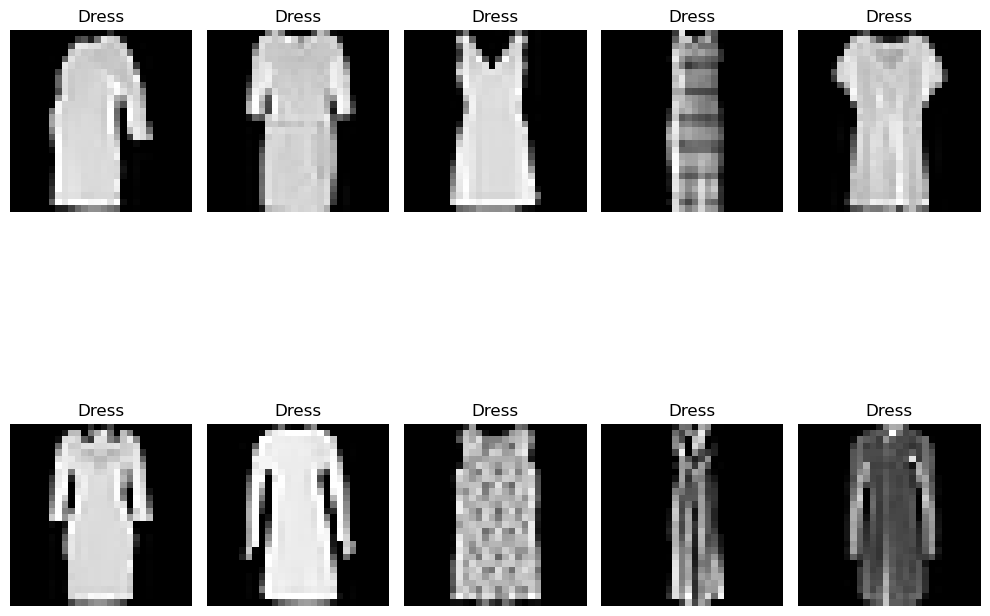

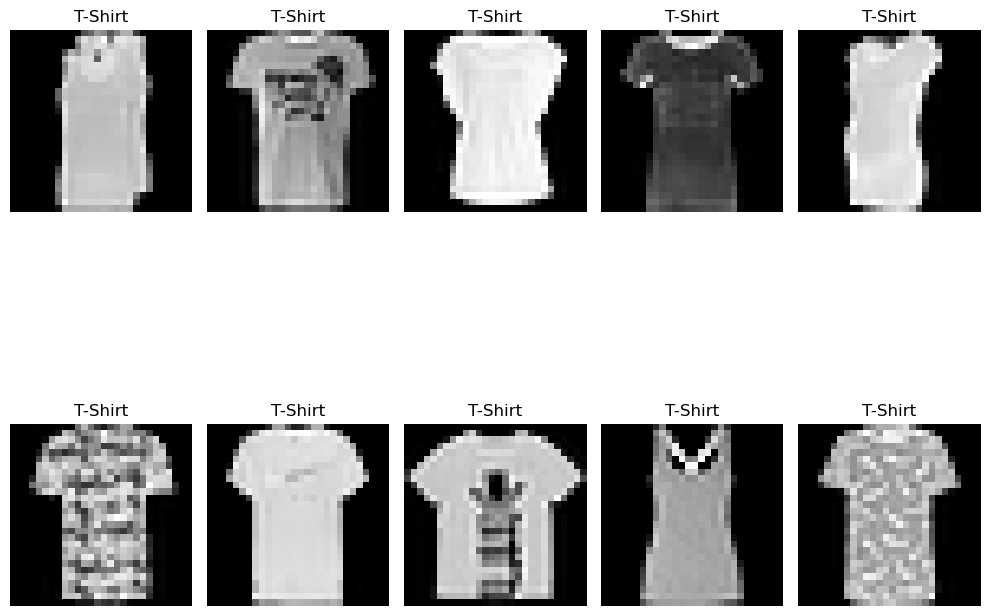

In [20]:
# Plot 10 dress images
plt.figure(figsize=(10, 10))
for i, img in enumerate(dress_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Dress")
plt.tight_layout()
plt.show()

# Plot 10 t-shirt images
plt.figure(figsize=(10, 10))
for i, img in enumerate(tshirt_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("T-Shirt")
plt.tight_layout()
plt.show()

We can see that there are T-shirts and dresses without sleeves and some are with. The model probanly distinguished between these difference in the same class.

#### Exponential Distribution

We chose the exponential distribution because it has similar characteristics to the laplace distribution - Sparse and heavy tail.
The probability density is highest near $0$ and decreases rapidly. That means the exponential distribution tends to produce values close to $0$ with usualy larger values. As a result, most latent dimensions remain inactive (close to zero), and only a few become active.
Moreover, regarding the heavy tail - the exponential decay still allows large values, and this helps balancing sparsity and the ability to capture significant deviations.

#### Training VAD with Exponential Distribution

Training the VAD model...
Epoch 1, Loss: 12352.0764
Epoch 2, Loss: 11403.5793
Epoch 3, Loss: 11289.2665
Epoch 4, Loss: 11168.3318
Epoch 5, Loss: 11072.5103
Epoch 6, Loss: 11009.6945
Epoch 7, Loss: 10980.3452
Epoch 8, Loss: 10969.3265
Epoch 9, Loss: 10951.6268
Epoch 10, Loss: 10930.6548
Epoch 11, Loss: 10921.4608
Epoch 12, Loss: 10864.7334
Epoch 13, Loss: 10830.0339
Epoch 14, Loss: 10799.0691
Epoch 15, Loss: 10754.2673
Epoch 16, Loss: 10867.3922
Epoch 17, Loss: 10692.7698
Epoch 18, Loss: 10669.7274
Epoch 19, Loss: 10657.5824
Epoch 20, Loss: 10637.9083
Epoch 21, Loss: 10596.4966
Epoch 22, Loss: 10564.6234
Epoch 23, Loss: 10532.0373
Epoch 24, Loss: 10543.0507
Epoch 25, Loss: 10503.6244
Epoch 26, Loss: 10488.9642
Epoch 27, Loss: 10471.6558
Epoch 28, Loss: 10461.5265
Epoch 29, Loss: 10441.2238
Epoch 30, Loss: 10425.3305
Epoch 31, Loss: 10424.3807
Epoch 32, Loss: 10422.4592
Epoch 33, Loss: 10425.0505
Epoch 34, Loss: 10508.8240
Epoch 35, Loss: 10416.5511
Epoch 36, Loss: 6210.7077
Epoch 37, Lo

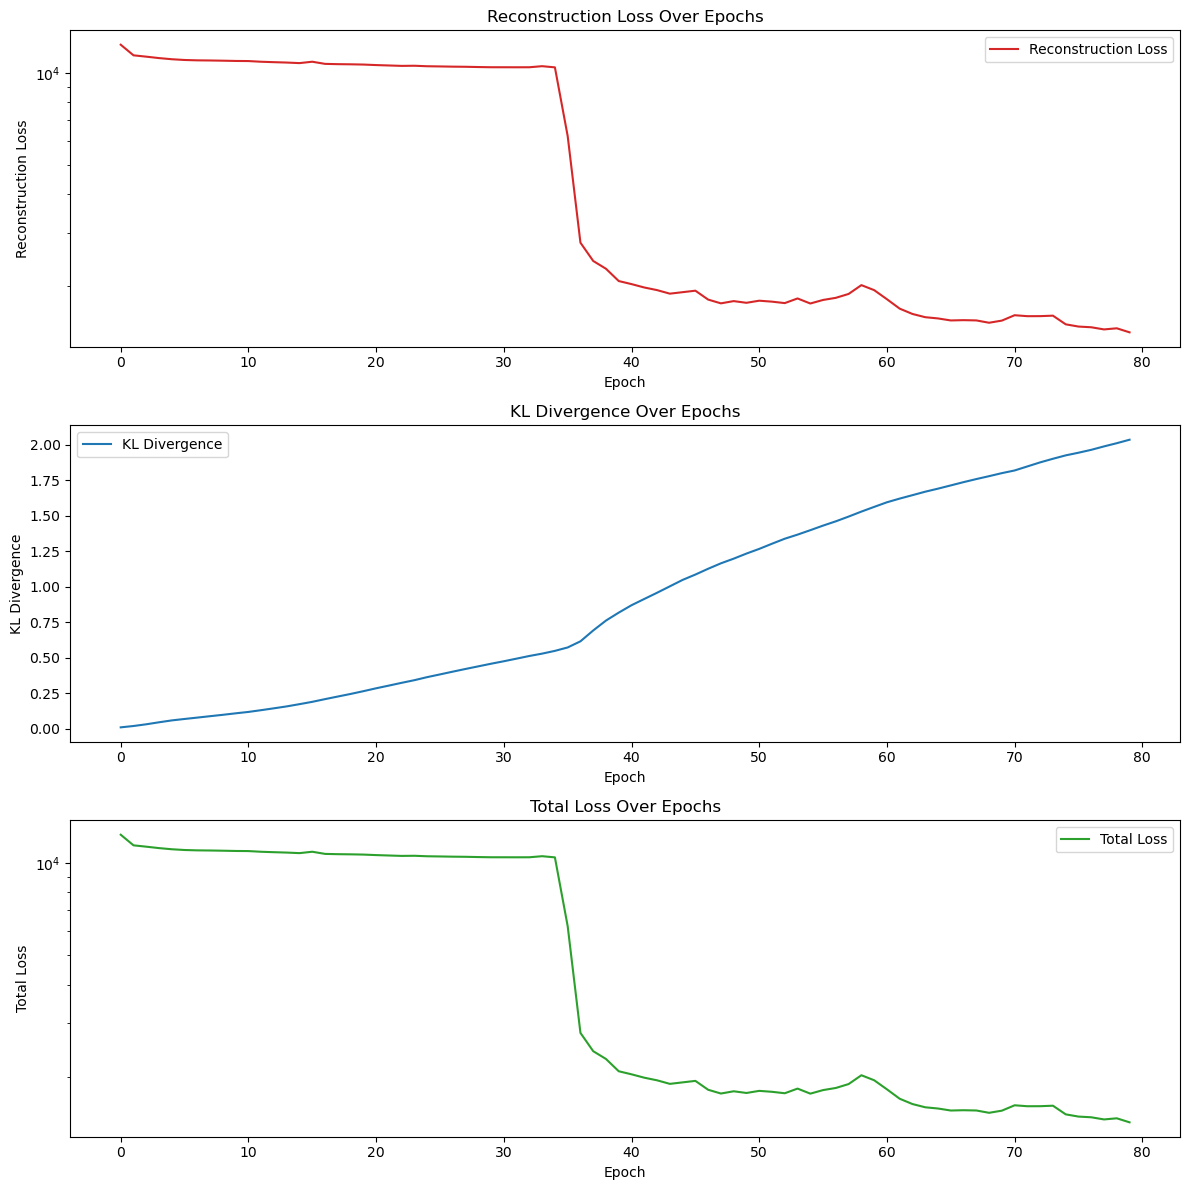

Training loss: 1419.7534
Testing the VAD model...
Test loss: 0.1562


In [6]:
epochs = 80
beta = 2.1
learning_rate = 0.03
latent_dim = 60
model_exp = VariationalAutoDecoderExponential(latent_dim=latent_dim,lr=learning_rate)
train_loss,_,_ = model_exp.train_model(num_epochs=epochs, beta=beta)
print(f'Training loss: {train_loss:.4f}')
test_loss = model_exp.test_vad(num_epochs=epochs, learning_rate=learning_rate)
print(f'Test loss: {test_loss:.4f}')

In [7]:
file_name = 'tsne_plot_VAD_exp'
image_title = 'TSNE Plot VAD Exponential Distribution'
model_exp.plot_tsne(file_name=file_name, plot_title=image_title)

Generating t-SNE plot...


<Figure size 800x600 with 0 Axes>

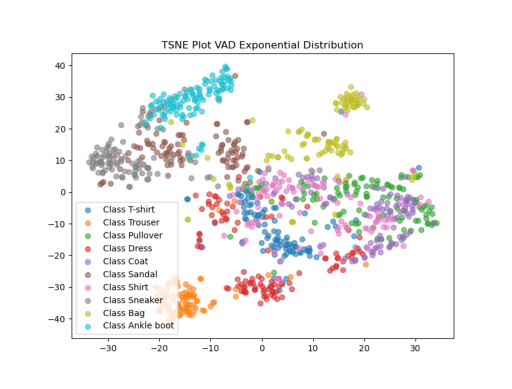

In [8]:
image_path = f'{file_name}.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Results Explanation
We can see that overall the classes are organized well, but there are some differences from the previous plots.
From the plot we can observe that the sandals class is sperated in to two areas indicating that the model learnt two different kind of sandals. Moreover we can see that the trousers class is seperated from other classes and very concetrated. The pullover class was learnt better than the previous models, as it is more less scattered around. Lastly, using the exponential distribution still did not help the model differtuate between the caot, pullover and shirt classes.

In [ ]:
# start_lr = np.log10(0.005)
# end_lr = np.log10(0.02)
# number_lr_vals = 10
# # Generate *10* values between these points in log space (you can adjust the number)
# learning_rates = np.logspace(start_lr, end_lr, num=number_lr_vals)
# print(f'learning rates: {learning_rates}')

# start_beta = np.log10(1)
# end_beta = np.log10(4.5)
# number_beta_vals = 10
# betas = np.logspace(start_beta, end_beta, num=number_beta_vals)
# print(f'betas: {betas}')

# start_epoch = 100
# end_epoch = 500
# number_epoch_vals = 10
# epochs = np.linspace(start_epoch, end_epoch, num=number_epoch_vals, dtype=int)
# print(f'epochs: {epochs}')

# test_losses, training_losses = [], []
# latent_dim = 60
# model = VariationalAutoDecoderNormal(latent_dim=latent_dim)
# print(model)


# min_lr = start_lr
# min_beta = start_beta
# min_epoch = start_epoch

# for lr in learning_rates:
#     for beta in betas:
#         for epoch in epochs:
#             train_loss = model.train_model(num_epochs=epoch, beta=beta, lr=lr)
#             print(f'Training loss: {train_loss:.4f}, learning rate: {lr}, beta: {beta}, epoch: {epoch}')
#             test_loss = model.test_vad(num_epochs=epoch, learnig_rate=lr)
#             print(f'Test loss: {test_loss:.4f}')

#             training_losses.append(train_loss)
#             test_losses.append(test_loss)
#             min_loss = min(test_losses)
#             if test_loss <= min_loss:
#                 min_lr = lr
#                 min_beta = beta
#                 min_epoch = epoch


# print(f'best test_loss: {min_loss}')
# print(f'best params: learning rate={min_lr}, beta={min_beta}, epoch={min_epoch}')
            


Training the VAD model...
Epoch 1, Loss: 13924.5605
Epoch 2, Loss: 13694.8160
Epoch 3, Loss: 13599.7604
Epoch 4, Loss: 13532.9856
Epoch 5, Loss: 13461.4772
Epoch 6, Loss: 13409.6979
Epoch 7, Loss: 13352.0615
Epoch 8, Loss: 13311.2335
Epoch 9, Loss: 13259.7672
Epoch 10, Loss: 13221.6662
Epoch 11, Loss: 13110.4846
Epoch 12, Loss: 12932.9478
Epoch 13, Loss: 9220.8817
Epoch 14, Loss: 7286.9846
Epoch 15, Loss: 6809.0726
Epoch 16, Loss: 6463.0247
Epoch 17, Loss: 5936.2902
Epoch 18, Loss: 5595.5197
Epoch 19, Loss: 5384.2225
Epoch 20, Loss: 4732.6823
Epoch 21, Loss: 4603.2745
Epoch 22, Loss: 4392.1928
Epoch 23, Loss: 4048.0118
Epoch 24, Loss: 3720.6948
Epoch 25, Loss: 3537.2777
Epoch 26, Loss: 3320.6962
Epoch 27, Loss: 3371.0255
Epoch 28, Loss: 3139.8891
Epoch 29, Loss: 2954.4722
Epoch 30, Loss: 2805.7686
Epoch 31, Loss: 2655.3173
Epoch 32, Loss: 2518.6398
Epoch 33, Loss: 2410.6246
Epoch 34, Loss: 2313.2957
Epoch 35, Loss: 2252.9497
Epoch 36, Loss: 2110.6911
Epoch 37, Loss: 2031.8660
Epoch 38,

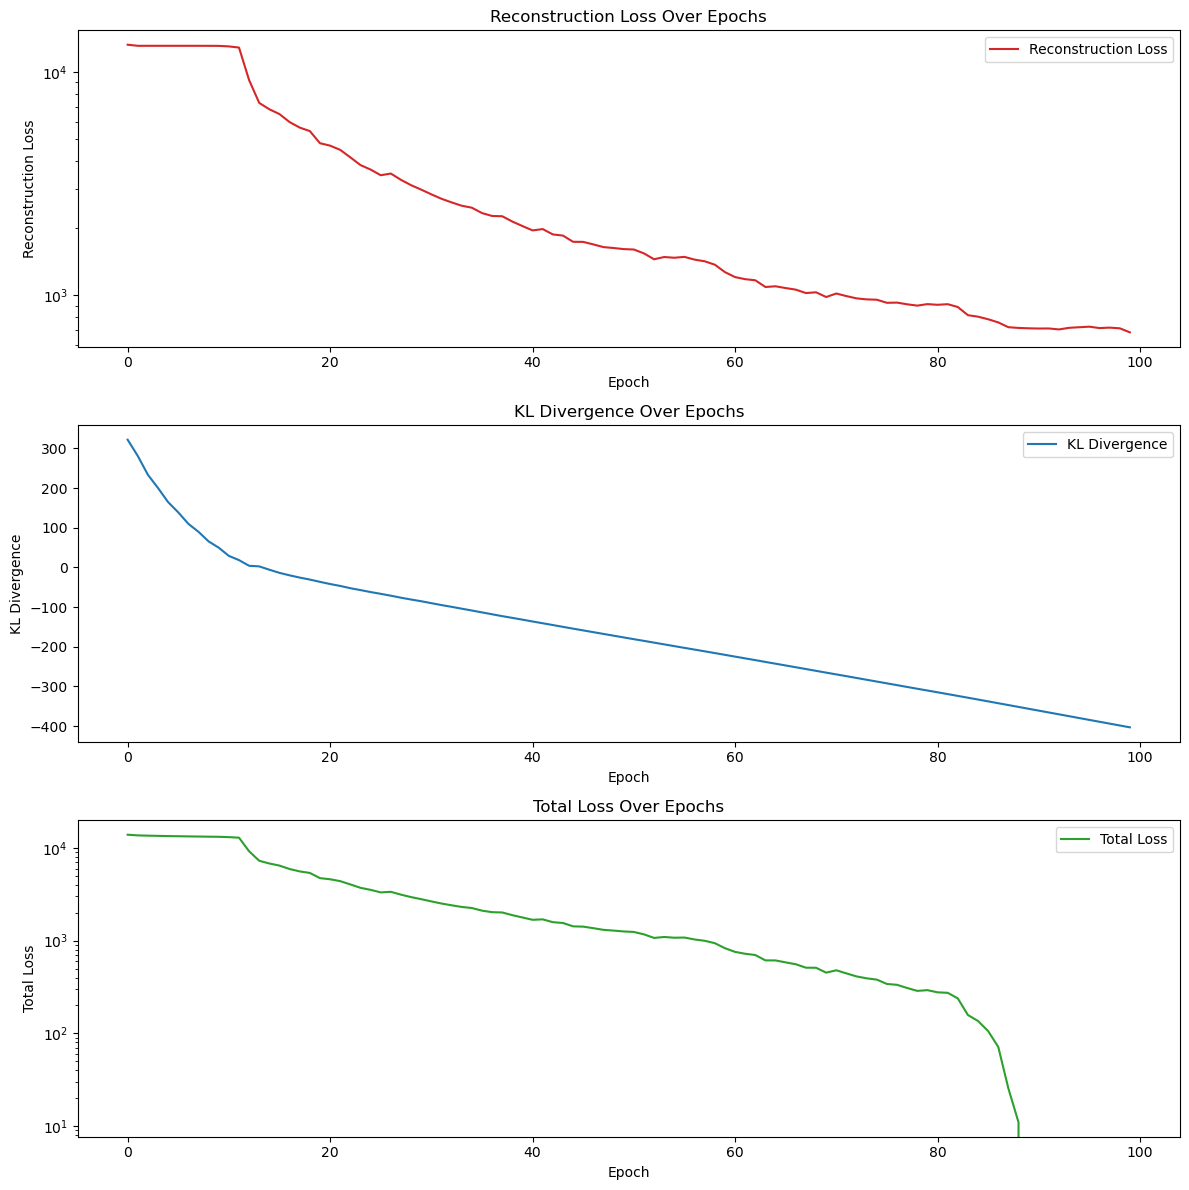

Training loss: -123.9236
Testing the VAD model...
Test loss: 0.1009


In [2]:
epochs = 100
beta = 2
learning_rate = 0.03
latent_dim = 60
model_test = VariationalAutoDecoderLaplace(latent_dim=latent_dim,lr=learning_rate)
train_loss,_,_ = model_test.train_model(num_epochs=epochs, beta=beta)
print(f'Training loss: {train_loss:.4f}')
test_loss = model_test.test_vad(num_epochs=epochs, learning_rate=learning_rate)
print(f'Test loss: {test_loss:.4f}')